In [1]:
!pip install efficientnet_pytorch

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
from path import Path
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
%cd /kaggle/input/siim-isic-melanoma-classification/



  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=96fc12c1f3722bb7b2e65d6209934383e80e990c6b3da336f0ad6fefbd5a1af3
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
/kaggle/input/siim-isic-melanoma-classification


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
IMG_SIZE= 1024

In [3]:
if IMG_SIZE==512:
    train_path = Path("/kaggle/input/melanoma-512/train_512/train_512/")
    test_path = Path("/kaggle/input/melanoma-512/test_512/test_512/")
else:
    train_path = Path("/kaggle/input/melanoma1024/train_1024/")
    test_path = Path("/kaggle/input/melanoma1024/test_1024/")

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [5]:
def read_image(path):
#     im = Image(path)
    im = cv2.imread(str(path))
    
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im/255.0 - imagenet_stats[0])/imagenet_stats[1]

def denormalize(img):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return img*imagenet_stats[1] + imagenet_stats[0]


class TrainDataset(Dataset):
    def __init__(self,train_path,csv_file,transform, balanced=True):
        df = pd.read_csv(csv_file)
        if balanced:
            train_0 = df[df['target']==0]
            train_1 = df[df['target']==1]
            train_0_sample = train_0.sample(int(train_1.shape[0]))
            df = pd.concat([train_0_sample, train_1]).reset_index(drop=True)
            
        self.df = df
        self.transform = transform
        self.train_path = train_path
        self.df["image_name"] = self.df["image_name"].apply(lambda x: f"{x}.jpg")
        self.image_names = self.df["image_name"].tolist()
        self.labels = self.df["target"].tolist()
        
        
        
        
        self.num_files = self.df.shape[0]
       
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        
        image_name = self.train_path/self.image_names[index]

        # Load the image
        
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = normalize(image)
        image = image.transpose(2,1,0)
        
#         image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
#         image = transforms.ToPILImage()(image)
        
#         if self.transform:
#             image = self.transform(image)
        

        
        y = self.labels[index]
        
        
        return image, y

class TestDataset(Dataset):
    def __init__(self,test_path,csv_file, transform):            
        self.df = pd.read_csv(csv_file)
        self.test_path =test_path
        self.df["image_name"] = self.df["image_name"].apply(lambda x: f"{x}.jpg")
        self.image_names = self.df["image_name"].tolist()
        self.transform = transform
        self.num_files = self.df.shape[0]
       
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        
        image_name = self.test_path/self.image_names[index]

        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = normalize(image)
        image = image.transpose(2,1,0)
        
#         if self.transform:
#             image = self.transform(image)      
        
        return self.image_names[index] , image
def initialize_train_loader(train_batch_size=32, val_batch_size=32):
    
    global train_path, train_transform
    
    dataset = TrainDataset(train_path,"train.csv",train_transform, balanced=True)
    train_len = int(len(dataset)*0.85)
    val_len  = len(dataset) - train_len
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_len,val_len ])
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size,num_workers=0, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=val_batch_size,num_workers=0, shuffle=True)
    return train_loader, valid_loader

def initialize_test_loader(batch_size=32):
    
    global test_path, train_transform
    
    dataset = TestDataset(test_path,"test.csv",train_transform)
    test_loader = DataLoader(dataset, batch_size=batch_size,num_workers=0, shuffle=False, drop_last=False)

    return test_loader 

def visualize_dataset(dataloader):
    """Imshow for Tensor."""
    x, y = next(iter(dataloader))
    
    
    fig = plt.figure(figsize=(10, 5))
    for i in range(4):
        inp = x[i]
        inp = inp.numpy().transpose(2,1,0)
        inp = denormalize(inp)

        
      
      
        ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
        plt.imshow(inp)

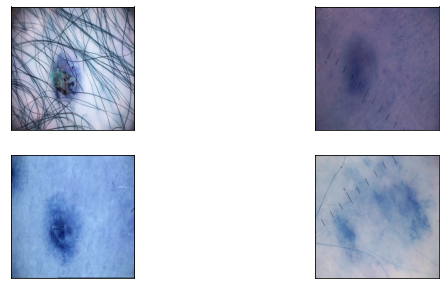

In [6]:
train_loader, valid_loader = initialize_train_loader()

visualize_dataset(train_loader)

In [7]:

from torch.nn import Conv2d
class UNet(nn.Module):
    def __init__(self,image_size,kernel=3, num_filters=32, num_colours=6, num_in_channels=3):
        super(UNet, self).__init__()

        
        padding = kernel // 2
      
        self.layer1 = nn.Sequential(Conv2d(in_channels=num_in_channels, out_channels= num_filters, 
                              kernel_size=kernel, padding=padding),
                              nn.MaxPool2d(kernel_size=2),
                              nn.BatchNorm2d(num_filters),
                              nn.ReLU()
                              ) 
        self.layer2 =nn.Sequential(Conv2d(in_channels=num_filters, out_channels= 2*num_filters, 
                              kernel_size=kernel, padding=padding),
                              nn.MaxPool2d(kernel_size=2),
                              nn.BatchNorm2d(2*num_filters),
                              nn.ReLU()
                              ) 
        self.layer3 =nn.Sequential(Conv2d(in_channels=2*num_filters, out_channels= 2*num_filters, 
                              kernel_size=kernel, padding=padding),
                              nn.BatchNorm2d(2*num_filters),
                              nn.ReLU())

        self.layer4 =nn.Sequential(Conv2d(in_channels=2*num_filters+ 2*num_filters, out_channels= num_filters, 
                              kernel_size=kernel, padding=padding),
                              nn.Upsample(scale_factor=2),
                              nn.BatchNorm2d(num_filters),
                              nn.ReLU()
                              )  
        
        self.layer5 =nn.Sequential(Conv2d(in_channels=2*num_filters, out_channels= num_colours, 
                              kernel_size=kernel, padding=padding),
                              nn.Upsample(scale_factor=2),
                              nn.BatchNorm2d(num_colours),
                              nn.ReLU()
                              ) 
        self.layer6 = nn.Sequential(nn.Linear((num_in_channels*(image_size)**2)+(num_colours*image_size*image_size), 128),
                                    nn.BatchNorm1d(128),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.5)
                                   )
        self.layer7 = nn.Sequential(nn.Linear(128,64),
                                    nn.BatchNorm1d(64),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.5))
        
        self.layer8 = nn.Linear(64,1)
        
        


    def forward(self, x):
        
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x3 = torch.cat([x3, x2], dim=1)
        x4 = self.layer4(x3)
        x4 = torch.cat([x4, x1], dim=1)
        x5 = self.layer5(x4)
        x = torch.cat([x5, x], dim=1)
        x = torch.flatten(x, 1)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        return x.float()


In [8]:
def compute_loss(pred, gt):
    
    loss = F.binary_cross_entropy_with_logits(pred.float(), gt.float())
    return loss


def compute_accuracy(x, y):
    
    acc = (x==y).sum().float()/len(y)
            
    return acc

def run_validation_step(args, epoch, model, loader, ):

    model.eval()  # Change model to 'eval' mode (BN uses moving mean/var).

    losses = []
    
    auc_scores = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            
            
            if args.gpu:
                images = images.cuda()
                labels = labels.cuda()
            
            output = model(images.float()).squeeze()
            
            pred = (output>=0.5).int()
            
            loss = compute_loss(output, labels)
            try:
                auc = roc_auc_score(labels.cpu().numpy(),output.cpu().numpy())
            except ValueError:
                continue
            
            
            auc_scores.append(auc)
            losses.append(loss.data.item())
            

        val_loss = np.mean(losses)
        val_auc = np.mean(auc_scores)
    
    
    return val_loss, val_auc



In [9]:
def get_data(train,valid):
    train_set =[]
    valid_set =[]
    for _, train_batch in enumerate(train):
        
        train_set.append(train_batch)
    for _, valid_batch in enumerate(valid):
        valid_set.append(valid_batch)
        
    return train_set, valid_set

In [10]:
from tqdm import tqdm
def train(args, model):
    
    
    save_dir = Path("/kaggle/working/")
    # Adam only updates learned_parameters
    if args.gpu:
        model.cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)
    train_loader, valid_loader = initialize_train_loader(args.train_batch_size,args.val_batch_size)
    if IMG_SIZE==512:
        train_loader , valid_loader = get_data(train_loader,valid_loader)
    print("Train set: {}, Test set: {}".format(
            len(train_loader), len(valid_loader)))
    

    print("Beginning training ...")
    
    

    start = time.time()
    trn_losses = []
    val_losses = []
    val_aucs =[]
    best_auc =0
    best_loss = 1000.0
    early_stop =0

    for epoch in range(args.epochs):

        # Train the Model
        model.train() # Change model to 'train' mode
        start_tr = time.time()
        
        
        losses = []
        scheduler.step()
        
        for i, (images, labels) in enumerate(train_loader):
            if args.gpu:
                images = images.cuda()
                labels = labels.cuda()

            # Forward + Backward + Optimize
            
            optimizer.zero_grad()
            output = model(images.float()).squeeze()
        
            
            
            loss = compute_loss(output, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

     
        # plot training images
        trn_loss = np.mean(losses)
        trn_losses.append(trn_loss)
        time_elapsed = time.time() - start_tr
        print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
                epoch+1, args.epochs, trn_loss, time_elapsed))

        # Evaluate the model
        start_val = time.time()
        val_loss,val_auc = run_validation_step(args, 
                                                epoch, 
                                                model,
                                                valid_loader)

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), save_dir/f"{args.checkpoint_name}-best.ckpt")
            
        if val_loss<best_loss:
            best_loss = val_loss
            early_stop=0
        else:
            early_stop+=1
            if early_stop>5:
                print('Best model achieves auc: %.4f' % best_auc)
                break
            
            

        time_elapsed = time.time() - start_val
        print(f'Epoch {epoch+1}/{args.epochs}, Loss: {val_loss}, AUC: {val_auc}, Validation time: {time_elapsed}' )
        
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        
    

    # Plot training curve
    plt.figure()
    plt.plot(trn_losses, "ro-", label="Train")
    plt.plot(val_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir/"training_curve.png")

    # Plot validation roc_auc curve
    plt.figure()
    plt.plot(val_aucs, "ro-", label="roc_auc")
    plt.legend()
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.savefig(save_dir/"val_auc_curve.png")

    print('Saving model...')
    torch.save(model.state_dict(), save_dir/f"{args.checkpoint_name}-last.ckpt")

    print('Best model achieves auc: %.4f' % best_auc)

In [11]:
# model = UNet(IMG_SIZE)
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b3',num_classes=1) 

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


Train set: 248, Test set: 44
Beginning training ...
Epoch [1/50], Loss: 0.6829, Time (s): 246
Epoch 1/50, Loss: 0.6728723174647281, AUC: 0.7280701754385965, Validation time: 21.817930936813354
Epoch [2/50], Loss: 0.6594, Time (s): 242
Epoch 2/50, Loss: 0.6413254059023328, AUC: 0.837962962962963, Validation time: 21.628390312194824
Epoch [3/50], Loss: 0.6280, Time (s): 242
Epoch 3/50, Loss: 0.5986380191837869, AUC: 0.8475609756097561, Validation time: 21.318515062332153
Epoch [4/50], Loss: 0.5928, Time (s): 243
Epoch 4/50, Loss: 0.5693327619841224, AUC: 0.7894736842105263, Validation time: 21.197264671325684
Epoch [5/50], Loss: 0.5772, Time (s): 243
Epoch 5/50, Loss: 0.5297495581601795, AUC: 0.8552631578947368, Validation time: 21.708330154418945
Epoch [6/50], Loss: 0.5404, Time (s): 241
Epoch 6/50, Loss: 0.5098231464624405, AUC: 0.8375, Validation time: 21.03527307510376
Epoch [7/50], Loss: 0.5515, Time (s): 242
Epoch 7/50, Loss: 0.49234248548746107, AUC: 0.8541666666666667, Validation

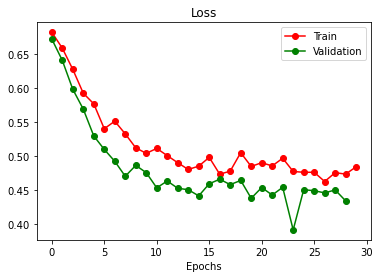

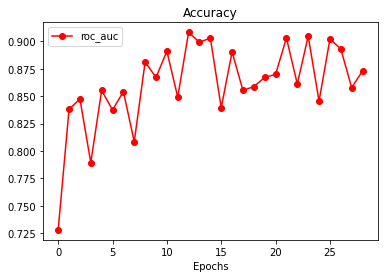

In [12]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict()
if IMG_SIZE==512:
    batch_size = 12
else:
    batch_size = 4

my_model_dict = {
              'gpu':True, 
              'checkpoint_name':"melanoma_1", 
              'lr':5e-6, 
              'train_batch_size':batch_size, 
              'val_batch_size': batch_size, 
              'epochs':50 ,
              'experiment_name': 'melanoma_1',
}
args.update(my_model_dict)
with torch.no_grad():
    torch.cuda.empty_cache()
# unet_model = UNet(1024)

# model_path = "/kaggle/output/melanoma_1-best.ckpt"
# if os.path.exists(model_path):
#     unet_model.load_state_dict(torch.load(model_path))


train(args, model)


In [13]:
def test(model):

    model.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    model.cuda()
    loader = initialize_test_loader(16)
    predictions = []
    image_names = []
    auc_scores = []
    with torch.no_grad():
        for i, (names, images) in tqdm(enumerate(loader)):
            
            
            
            images = images.cuda()
                
            
            output = model(images.float()).squeeze()
            output = F.sigmoid(output)
            predictions.append(output.cpu().numpy())
            image_names.append(names)
    predictions = np.concatenate(predictions,axis=0)
    image_names = np.concatenate(image_names,axis=0)       
    return image_names, predictions

In [14]:
# model = UNet(IMG_SIZE)
model_path = "/kaggle/working/melanoma_1-best.ckpt"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    
image_names, predictions = test(model)

test_df = pd.read_csv("test.csv")
test_df["target"] = predictions
submission =test_df[["image_name","target"]]
submission.to_csv("/kaggle/working/submission.csv",index=None)

687it [21:38,  1.89s/it]


In [15]:
submission.to_csv("/kaggle/working/submission.csv",index=None)

In [16]:
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m "Message"

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
